In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from bs4 import BeautifulSoup
import pyodbc
import requests
import json

# Step 0: Managing a Log File

- This step is done to record the logs while performing ETL for safe side

In [4]:
def log_process(message):
    """This function logs the mentioned message of a given stage of the
    code execution to a log file. Function returns nothing"""

    with open('./log/code_log.txt','a') as f:
        f.write(f'{datetime.now()}: {message} \n')

# Step 1: Extracting

- This step is done to extract the data from the website

In [5]:
def extract():

    """server ne reuest suni lekin accept nhi ki and block kar diya scraping karne se Bahut websites scraping block karti hain — jaise PakWheels, OLX, LinkedIn, etc.
    Agar aap requests.get() se hit karte ho, wo block kar dete hain → 403."""

    # jab ham requests.get(url) se hit karte hain yani request bhejte hain tu kuch website allow kardeti hain and response 200 ajata hai mtlb sab sahi hua, lekin kuch website allow nhi karti and block kardeti hain phir 403 forbidden show karti hain kyun ke us ko lagta hai ham browser ki tarha request nhi bhej rahey, Server ko lagta hai ke request bot ne bheji hai isi liyen block kar deta hai tu ham ek headers banate hain and us mein cheexein likhte hain phir jab requests.get(url,headers=headers) karte hain tu response 200 ajata hai kyun ke Isse website ko lagta hai ke browser request bhej raha, script nahi.
    all_cars=[]
    for page in range(1,11):
        url = f"https://www.pakwheels.com/used-cars/search/-/ct_karachi/?page={page}"
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0 Safari/537.36",
            "Accept-Language": "en-US,en;q=0.9",
            "Referer": "https://www.google.com/"
        }
        response = requests.get(url,headers=headers)  
        # print(response) # response 200 mtlb reuest accept karli ab server hamein do cheezein bhejta hai pheli: Response Headers and dusri: Response Body 
        # for key, value in response.headers.items(): # yeh karne se pata chal ke content type kiya hai, mtlb server kis type ka data bhej raha hai lekin server jo hai confuse karne ke liyen bhi galat type batat hai yani bolega javascript bhej html raha hai isi liyen ham us data ko 100 percent confirm karne ke liyen us ke andar ka content check karen gey 
        #     if key == 'Content-Type':
        #         print(f'{key}: {value}')
        # print(response.text[:500])  pata chal server fool bana raha tha bhej wo html mein raha hai tu isis liyen ham .text kar ke get karengey 

        # response.text:  but .text us data ko string mein conert kar deta hai and raw data deta hai, Matlab server se jo .text mila, wo bas ek raw string hai — HTML, JSON, ya JavaScript. Usme se specific information nikalne ke liye parse karte hain.

        soup = BeautifulSoup(response.text, 'html.parser')
        all_uls = soup.find_all('ul',class_='list-unstyled search-results search-results-mid next-prev car-search-results') # saare ul lake dega jis mein class attribute ki value exactly yeh (list-unstyled search-results search-results-mid next-prev car-search-results) hogi
        
        for ul in all_uls:
            all_lis = ul.select('li.classified-listing') # yeh saare lis lake dega jo us particular ul mein hain and un ki class ke naam mein classified-listing ata ho khain bhi 

            for li in all_lis:
                script_tag = li.find('script')
                if script_tag:
                    # print(script_tag.text) # .text jo hai wo string wrapper mein daal deta hai jis wajha se data type string ban jati hai 
                    data = json.loads(script_tag.text)
                    new_dict = {
                        'name':data.get('description'),
                        'year':data.get('modelDate'),
                        'brand':data.get('manufacturer'),
                        'mileage':data.get('mileageFromOdometer'),
                        'prices':data.get('offers',{}).get('price'),
                        'engine':data.get('vehicleEngine',{}).get('engineDisplacement','None'),
                        'vehicle_Transmission':data.get('vehicleTransmission'),
                        'fuel_type':data.get('fuelType')
                    }
                    
                    all_cars.append(json.dumps(new_dict))

    log_process('extraction complete')

    return all_cars

# Step 2: loading raw data to csv

- This step is done to record raw data from the website

In [6]:
def load_raw_data_to_csv(all_cars):

    pd.DataFrame({'cars_data':all_cars}).to_csv('./output/raw.csv',index=False)

    cars = []
    for x in all_cars:
        cars.append(json.loads(x))
    
    log_process('loading raw data to csv is complete')
    return cars

# Step 2: transforming the raw data

- This step is done to do expolatory data analysis

In [7]:
def transform(data):

    df = pd.DataFrame(data)
   
    # JAB RAW DATA MIL GAYA AND US RAW DATA KO CSV MEIN STORE BHI KARA DIYA AB TRANSFORM KA PART ATA HAI JSI MEIN SAB SE PHELA KAAM RAW DATA KO DATAFRAME BANANA HAI US KE BAD DATA KO UNDERSTAND KARNA HAI 
    # basic info
    
    print(df.shape,end='\n')
    print(df.head(),end='\n')
    print(df.dtypes,end='\n')
    print(df.columns,end='\n')

    # ab dekhengey ke kitne null hain har column mein  yad rahey yeh sirf  (np.nan = NaN, None, pd.NA = <NA>, float("nan") = NaN) yehi detect karega

    null_string = ["", " ", "N/A", "n/a", "NA", "None", "none", "null", "Null", "unknown", "-", "--"]

    df = df.replace(null_string, np.nan)

    # df.isnull().sum() # yeh har column mein jitne missing value hain wo batayega 

    print(df.isnull().sum().sum())

    print(df['mileage'].sample(5)) 
    print(df['engine'].sample(5))
    print(df['prices'].sample(5))

    # NORMALIZE COLUMN NAME MTLB SAB KE NAAM LOWER CASE MEIN AND DO WORD MEIN GAP KI BAJAYE UNDERSCORE
    
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # HANDLE MISSING VALUES 

    df['brand'] = df['brand'].fillna('unknown')

    # CLEAN AND CONVERT NUMERIC COLUMNS 

    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64') # pd.to_numeric se agar missing value hogi jis row mein us ko kuch nhi karega and jahan value hogi wahan int kar dega
    df['mileage'] = df['mileage'].str.replace('km','').str.replace(',','').str.strip()
    df['mileage'] = pd.to_numeric(df['mileage'],errors='coerce').astype('Int64')
    df['prices'] = pd.to_numeric(df['prices'],errors='coerce').astype('Int64')
    df['engine'] = df['engine'].str.replace('cc','').str.strip()
    df['engine'] = pd.to_numeric(df['engine'],errors='coerce').astype('Int64')
    df['name'] = df['name'].str.replace('for sale in Karachi','')
    df['name'] = df['name'].str.split().str[:2].str.join(' ').str.strip()
    df['brand'] = df['brand'].str.strip()
    df['vehicle_transmission'] = df['vehicle_transmission'].str.strip()
    df['fuel_type'] = df['fuel_type'].str.strip()

    print(df.duplicated().sum()) # yeh poorey dataframe mein dekhta hai ke wo row exactly repeat horahi hai tu count karta hai YANI SAARE COLUMNS KI VALUE KO DEKHTA HAI 

    df = df.drop_duplicates()

    # outliers mtlb jo extreme values hain column mein wo row hata dega or yeh sirf numeric columns par lagta hai
    numeric_cols = ['year', 'mileage', 'prices', 'engine']

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Optional: Print stats
        print(f"{col}: Lower={lower_bound}, Upper={upper_bound}")

        # Remove outliers (row delete)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    log_process('transforming is complete')
    
    return df

    





# Step 3: LOADING THE TRANSFORM DATA TO CSV

- This step is done to record the logs while performing ETL for safe side

In [8]:
def load_transform_to_csv(df):
    
    df.to_csv('./output/clean.csv',index=False)

    log_process('loading clean data is complete')


# STEP 4: CREATING ANALYSIS ON TRANSFORM DATA
## ANALYSIS #1

In [9]:
def analysis1(df):
    df.groupby('brand')['prices'].mean().plot(kind='bar')
    plt.xlabel("Brand")
    plt.ylabel("Average Price")
    plt.title("Average Car Price by Brand")
    plt.show()

    log_process('analysis1 is complete')




In [10]:
def analysis2(df):
    df.plot(kind='scatter', x='engine', y='prices')
    plt.title("Engine Size vs Price")
    plt.show()

    log_process('analysis2 is complete')
    


In [11]:
def analysis3(df):
    df['fuel_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title("Fuel Type Distribution")
    plt.show()

    log_process('analysis3 is complete')


In [12]:
def analysis4(df):
    df.plot(kind='scatter', x='mileage', y='prices')
    plt.title("Mileage vs Price")
    plt.show()

    log_process('analysis4 is complete')


In [13]:
def analysis5(df):
    df['year'].value_counts().sort_index().plot(kind='bar')
    plt.title("Cars Count by Model Year")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.show()

    log_process('analysis5 is complete')


# STEP #5 LOADING DATA TO SL 
## CREATING DATABASE

In [14]:
def create_database(query):
    conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-OU7EENT;"
    "Trusted_Connection=yes;"
    )

    with pyodbc.connect(conn_str,autocommit=True) as conn:
        cursor = conn.cursor()
        cursor.execute(query)
    
    log_process('database is created completely')
    return f'database is created successfully'

## CREATING TABLE 

In [15]:
def create_table(query,db):
    conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-OU7EENT;"
    "Trusted_Connection=yes;"
    f"Database={db};"
    )


    with pyodbc.connect(conn_str,autocommit=True) as conn:
        cursor = conn.cursor()
        cursor.execute(query)

    log_process('table is created completely')
    return f'table is created successfully'

## INSERTING VALUES

In [16]:
def insert_values(query,df,db):
    conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-OU7EENT;"
    "Trusted_Connection=yes;"
    f"Database={db};"
    )
    
    with pyodbc.connect(conn_str) as conn:
        cursor = conn.cursor()
        for lab,val in df.iterrows():
            cursor.execute(query,
            val['name'], val['year'], val['brand'], val['mileage'], val['prices'], val['engine'], val['vehicle_transmission'], val['fuel_type'])
        conn.commit()

    log_process('value is inserted completely')
    return f'values are inserted successfully'

## RUNNING qUERY

In [17]:
def run_query(query,db):

    conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-OU7EENT;"
    "Trusted_Connection=yes;"
    f"Database={db};"
    )

    with pyodbc.connect(conn_str) as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        result = cursor.fetchall()

    log_process('query is running completely')
    return result

    

# EXECUTING PIPELINE

(321, 8)
                                              name    year   brand    mileage  \
0            Toyota Raize 2020 for sale in Karachi  2020.0  Toyota  57,000 km   
1            Toyota Prado 2017 for sale in Karachi  2017.0  Toyota  87,000 km   
2  Toyota Yaris Hatchback 2022 for sale in Karachi  2022.0  Toyota  70,000 km   
3          Toyota Corolla 2024 for sale in Karachi  2024.0  Toyota   8,000 km   
4             Suzuki Alto 2023 for sale in Karachi  2023.0  Suzuki  78,000 km   

       prices  engine vehicle_Transmission fuel_type  
0   5600000.0  1000cc            Automatic    Petrol  
1  22500000.0  2700cc            Automatic    Petrol  
2   4450000.0  1000cc            Automatic    Petrol  
3   7550000.0  1800cc            Automatic    Petrol  
4   2950000.0   660cc            Automatic    Petrol  
name                     object
year                    float64
brand                    object
mileage                  object
prices                  float64
engine        

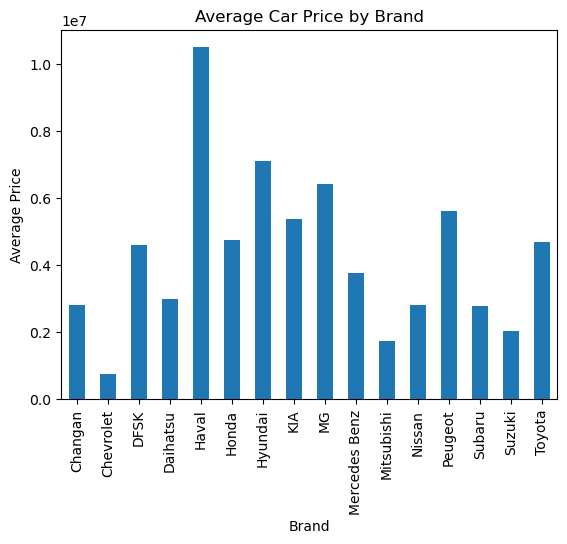

None


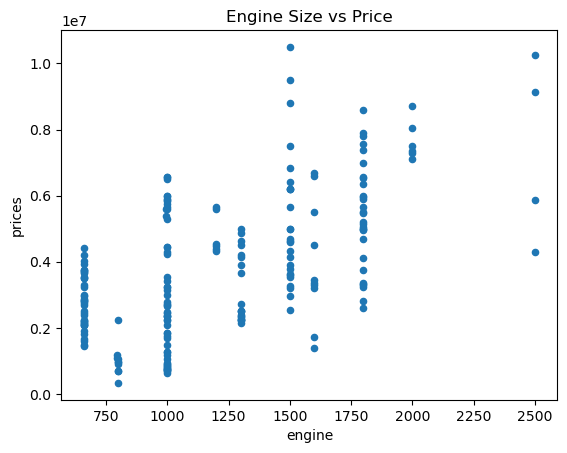

None


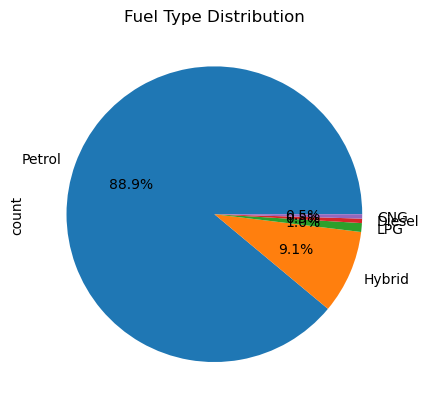

None


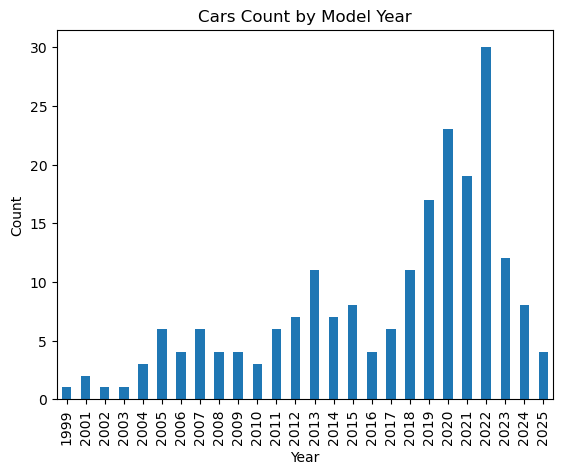

None
database is created successfully
table is created successfully
values are inserted successfully
[('Toyota Raize', 2020, 'Toyota', 57000, 5600000, 1000, 'Automatic', 'Petrol'), ('Toyota Yaris', 2022, 'Toyota', 70000, 4450000, 1000, 'Automatic', 'Petrol'), ('Toyota Corolla', 2024, 'Toyota', 8000, 7550000, 1800, 'Automatic', 'Petrol'), ('Suzuki Alto', 2023, 'Suzuki', 78000, 2950000, 660, 'Automatic', 'Petrol'), ('Toyota C-HR', 2018, 'Toyota', 99000, 7375000, 1800, 'Automatic', 'Hybrid'), ('Toyota Yaris', 2022, 'Toyota', 45000, 5600000, 996, 'Automatic', 'Petrol'), ('KIA Sportage', 2022, 'KIA', 38000, 7500000, 2000, 'Automatic', 'Petrol'), ('Daihatsu Mira', 2022, 'Daihatsu', 9500, 4425000, 660, 'Automatic', 'Petrol'), ('Hyundai Sonata', 2022, 'Hyundai', 30000, 9145000, 2500, 'Automatic', 'Petrol'), ('Suzuki Wagon', 2022, 'Suzuki', 85000, 3650000, 660, 'Automatic', 'Hybrid'), ('Honda Civic', 2020, 'Honda', 68000, 5950000, 1800, 'Automatic', 'Petrol'), ('Suzuki Mehran', 2018, 'Suzuki', 

In [18]:
if __name__ == '__main__':

    all_cars = extract()

    cars = load_raw_data_to_csv(all_cars)

    df = transform(cars)

    load_transform_to_csv(df)
    

    print(analysis1(df))
    print(analysis2(df))
    print(analysis3(df))
    print(analysis5(df))

    print(create_database('CREATE DATABASE ETL'))


    print(create_table(""" CREATE TABLE Pak_Wheels(
                            name varchar(50),
                            year int,
                            brand varchar(50),
                            mileage int,
                            prices int,
                            engine int,
                            vehicle_transmission varchar(50),
                            fuel_type varchar(50)
                   )

    """,'ETL'))


    print(insert_values(""" INSERT INTO Pak_Wheels (name, year, brand, mileage, prices, engine, vehicle_transmission, fuel_type)
                       VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """,df,'ETL'))
    

    print(run_query('SELECT * FROM Pak_Wheels','ETL'))
